In [1]:
import sys
sys.path.insert(0, '../../stock_factor_lab/')

In [2]:
START_DATE = '2003-3-31'
END_DATE = '2009-3-31'

# 整理暑假的程式

### 回測期間 - 2003/3/31  ~ 2009/3/31 

## import

In [ ]:
import talib
from get_data import Data
import backtest
from combinations import sim_conditions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# import plotly.graph_objs as go
import plotly.express as px
from itertools import cycle
from plotly.subplots import make_subplots
from matplotlib import rcParams
rcParams['font.sans-serif'] = ['Microsoft JhengHei']
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from datetime import datetime

from dataframe import CustomDataFrame

import plot_data

## get data

In [4]:
data=Data()

---

## 資料下載

### **盈餘再投資率**

In [5]:
profit = data.get('annual_report_fundamentals:常續性稅後淨利')

In [6]:
# 抓資料
long_term_items = [
    '透過損益按公允價值衡量之金融資產－非流動',
    '透過其他綜合損益按公允價值衡量之金融資產－非流動',
    '按攤銷後成本衡量之金融資產－非流動',
    '避險之金融資產－非流動',
    '合約資產－非流動',
    '採權益法之長期股權投資',
    '預付投資款',
    '投資性不動產淨額'
]

# 長期投資項目 (8個)
long_term_data = [data.get(f'annual_report_fundamentals:{item}').fillna(0) for item in long_term_items]
long_term_investment = sum(long_term_data)
# 固定資產
fixed_assets_year = data.get('annual_report_fundamentals:不動產廠房及設備').fillna(0)

In [7]:
# 計算盈再率分子
long_term_investment_df = (long_term_investment - long_term_investment.shift(4))#['2000':].astype('int64')
fixed_assets_df = (fixed_assets_year - fixed_assets_year.shift(4))#['2000':].astype('int64')

In [8]:
profit_rol_df = profit.rolling(4).sum()#['2000':]

In [9]:
# 計算出盈再率
# 去掉淨利為負的公司 (當年度淨利為負、四年加總淨利為負都去掉)
rr = (long_term_investment_df + fixed_assets_df) / profit_rol_df
rr = rr[(profit > 0) & (profit_rol_df > 0)]

### 盈再率 - 數值分佈

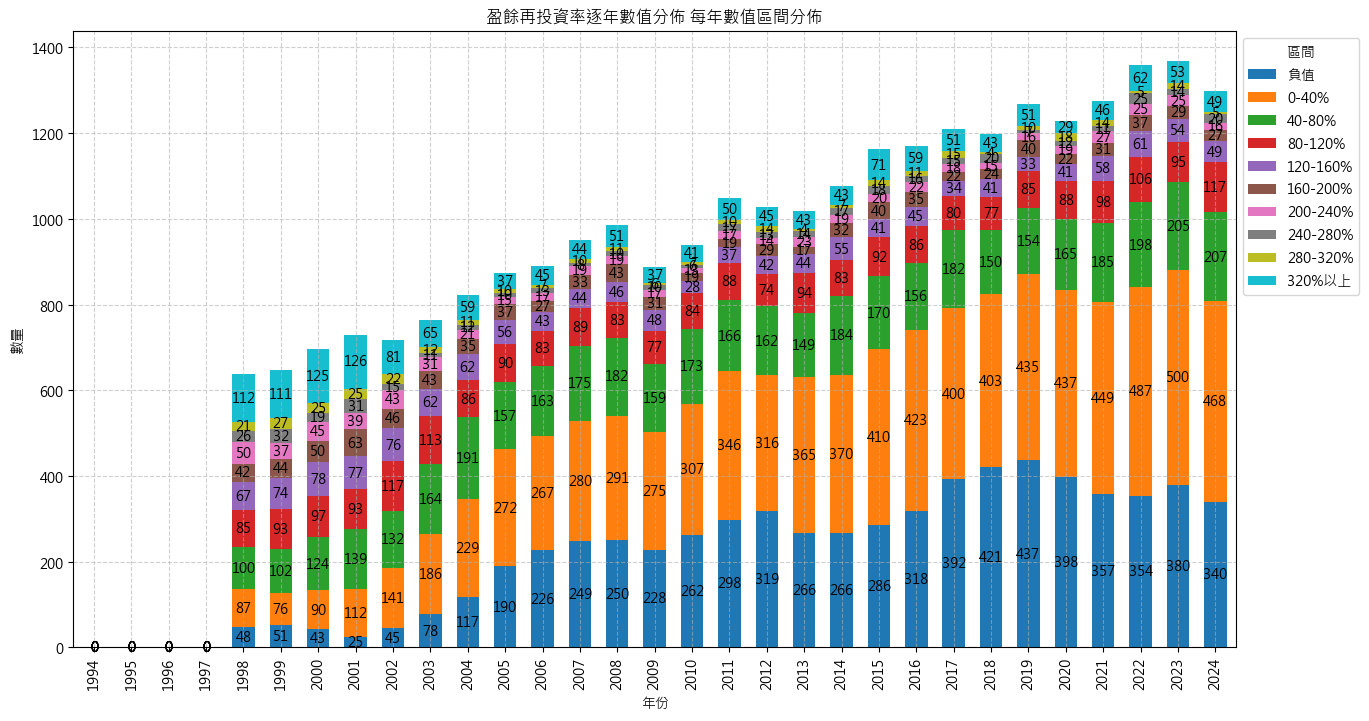

In [10]:
plot_data.numeric_bins(rr, "盈餘再投資率逐年數值分佈", stacked=True, num_label=True,
                bins=[-np.inf, 0, 0.40, 0.80, 1.20, 1.60, 2.00, 2.40, 2.80, 3.20, np.inf], 
                labels=['負值' ,'0-40%', '40-80%', '80-120%', '120-160%', '160-200%', '200-240%', '240-280%', '280-320%', '320%以上'])

---

### **本益比 (P/E)**
- 每季資料
- 每日資料

In [11]:
pe = data.get('quarter_report:PE') #[START_DATE:END_DATE]
daily_pe = data.get('price:daily_pe') #[START_DATE:END_DATE]

### **其他因子**

- ROE (季資料，取第四季)
- 股利支付率 (只有年資料) ＝〈現金股利總額〈元〉／ 股利分配年度之稅後淨利〉x 100
- 董監持股 (沒有每年的資料，缺值採向前補值)
- 上市上櫃滿兩年

In [12]:
roe = data.get('annual_report:ROE')
payout_ratio = data.get('annual_report_fundamentals:股利支付率')

In [13]:
stock_hold = data.get('annual_report_fundamentals:董監持股%')

In [14]:
# listed_date = pd.read_csv('../2024_code/最近上市日.csv', encoding='cp950')

##### 上市上櫃滿兩年

In [15]:
close = data.get('price:close')
comp_profile = data.get('company_profile')



stock_data = {}

for index, row in comp_profile.iterrows():
    stock_code = row['company_symbol']
    listed_date_ = row['ipo_date']
    end_date = listed_date_ + pd.DateOffset(years=2)
    
    # 創建一個全為 True 的 series
    series = pd.Series(True, index=close.index)
    # 在上市日之前和之後兩年內設置為 False
    series.loc[:end_date] = False
    
    stock_data[stock_code] = series

listed = pd.concat(stock_data, axis=1)

---

## 選股條件
- ROE 五年平均 > 15%
- 盈再率 < 80%
- 稅後淨利 > 五億
- 配息 > 40%
- 董監持股 > 10%
- 上市上櫃滿兩年
- PE < 12買入，>30賣出

In [16]:
# ROE 5年平均 > 15%
roe_rol = roe.rolling(5).mean()
roe_15 = (roe_rol > 15)

In [17]:
rr_cond = (rr < 0.4)

In [18]:
# *最近3年的配息率有無一年不及40%*
payout_ratio_cond = (payout_ratio.rolling(3).min() >= 40)

# # 金融股看配息率，不看盈再率
# rr_cond[finance_stock_list] = payout_ratio_cond[finance_stock_list]

In [19]:
# 淨利 > 5億
profit_cond = (profit > 500000) # TEJ 的淨利單位是千元

In [20]:
hold_cond = stock_hold > 10

In [21]:
listed = listed.resample('M').last()

---

## 原始條件 + 無本益比進出場條件

In [27]:
def trades_cagr_analysis_split_returns(
    factor_cond, factor, title, N=5, split_date='2008-03', start_date='2003-03', end_date='2009-03', 
    data=data, remove=False, interval_range=(15, 50, 5),
    percentage=True
):
    
    split_date = pd.Timestamp(split_date)

    
    rep = backtest.sim(factor_cond[start_date:end_date], resample='M', data=data)
    trades = rep.trades

    # 個股每月報酬率
    monthly_returns = ((rep.cashflow.resample('M').last() / rep.cashflow.resample('M').first()) - 1).resample('A-MAR').sum()

    # 分段結果存放
    x_values_first, y_values_first, stock_ids_first = [], [], []
    x_values_second, y_values_second, stock_ids_second = [], [], []

    # 逐筆查看交易明細中的個股
    for trade_id, row in trades.iterrows():
        entry_date = row['entry_sig_date']
        exit_date = row['exit_sig_date']
        stock_id = trades['stock_id'][trade_id]

        # 如果出場日為 NaN，設定 exit_date 為分析的 end_date
        if pd.isna(exit_date):
            exit_date = pd.Timestamp(end_date)

        factor_series = factor[stock_id][:pd.Timestamp(entry_date) + pd.DateOffset(days=1)].dropna()
        if not factor_series.empty:
            factor_value = factor_series.iloc[-1] * 100 if percentage else factor_series.iloc[-1]/100000
        else:
            # 如果所有值都是 NaN，則跳過該交易
            continue

        if factor_value is not None:
            if entry_date < split_date:
                if exit_date <= split_date:
                    y_value = monthly_returns.loc[entry_date:exit_date, stock_id].sum() / (pd.Timedelta(exit_date - entry_date).days / 365)
                    x_values_first.append(factor_value)
                    y_values_first.append(y_value)
                    stock_ids_first.append(stock_id)
                else:  # 如果出場日跨越 split_date
                    y_value_first = monthly_returns.loc[entry_date:split_date, stock_id].sum() / (pd.Timedelta(split_date - entry_date).days / 365)
                    x_values_first.append(factor_value)
                    y_values_first.append(y_value_first)
                    stock_ids_first.append(stock_id)

                    y_value_second = monthly_returns.loc[split_date:exit_date, stock_id].sum()
                    x_values_second.append(factor_value)
                    y_values_second.append(y_value_second)
                    stock_ids_second.append(stock_id)
            else: # 進場日在 split_date 之後
                y_value = monthly_returns.loc[entry_date:exit_date, stock_id].sum()
                x_values_second.append(factor_value)
                y_values_second.append(y_value)
                stock_ids_second.append(stock_id)
        else:
            print(f"{stock_id} - value is None or invalid pdays for {entry_date}")

    # 去除極端值
    def filter_extreme_percent(x_values, y_values, stock_ids, N):
        x_values = np.array(x_values)
        y_values = np.array(y_values)
        stock_ids = np.array(stock_ids)

        x_lower, x_upper = np.percentile(x_values, [N, 100 - N])
        y_lower, y_upper = np.percentile(y_values, [N, 100 - N])

        valid_indices = np.where((x_values >= x_lower) & (x_values <= x_upper) &
                                 (y_values >= y_lower) & (y_values <= y_upper))[0]

        return x_values[valid_indices], y_values[valid_indices]

    if remove:
        x_values_first, y_values_first = filter_extreme_percent(x_values_first, y_values_first, stock_ids_first, N)
        x_values_second, y_values_second = filter_extreme_percent(x_values_second, y_values_second, stock_ids_second, N)

    # 分類報酬率值的區間
    interval_start, interval_end, interval_step = interval_range
    x_labels = [f" "] + [f"{i}" for i in range(interval_start, interval_end, interval_step)] + [f"{interval_end}"]
    num_intervals = len(x_labels)

    def categorize_to_intervals(values, interval_start, interval_end, interval_step):
        categorized_values = []
        for value in values:
            if value < interval_start:
                categorized_values.append(interval_start - interval_step)
            elif value >= interval_end:
                categorized_values.append(interval_end)
            else:
                categorized_values.append(int((value - interval_start) // interval_step) * interval_step + interval_start)
        return categorized_values

    x_intervals_first = categorize_to_intervals(x_values_first, interval_start, interval_end, interval_step)
    x_intervals_second = categorize_to_intervals(x_values_second, interval_start, interval_end, interval_step)

    # 將每個點的位置根據區間偏移，保留原始相對位置，並固定區間大小，所有區間寬度一致
    def map_to_fixed_intervals(values, interval_start, interval_end, interval_step, num_intervals):
        mapped_values = []
        for value in values:
            if value >= interval_end:
                mapped_values.append(num_intervals - 1 + np.random.uniform(0.02, 0.98))
            elif value < interval_start:
                mapped_values.append(0 + np.random.uniform(0.02, 0.98))
            else:
                closest_interval = int((value - interval_start) // interval_step)
                mapped_values.append(closest_interval + 1 + np.random.uniform(0.02, 0.98))
        return mapped_values

    x_values_first_mapped = map_to_fixed_intervals(x_intervals_first, interval_start, interval_end, interval_step, num_intervals)
    x_values_second_mapped = map_to_fixed_intervals(x_intervals_second, interval_start, interval_end, interval_step, num_intervals)

    # 繪圖
    plt.figure(figsize=(12, 8))
    plt.axhline(y=0, color='r', linestyle='--', linewidth=0.6, alpha=0.6)

    plt.scatter(x_values_first_mapped, y_values_first, color='tab:blue', alpha=0.6, s=4, label=f"{start_date}~{split_date.strftime('%Y-%m')}")
    plt.scatter(x_values_second_mapped, y_values_second, color='tab:orange', alpha=0.4, s=4, label=f"{split_date.strftime('%Y-%m')}~{end_date}")

    plt.title(f"【{start_date}~{end_date}】{title} 與 股票報酬加總")
    plt.xlabel(f"一開始進場時的{title}")
    plt.ylabel("個別股票的月度報酬加總")
    plt.xticks(ticks=np.arange(num_intervals), labels=x_labels)
    plt.legend()
    plt.grid(True)

    plt.show()


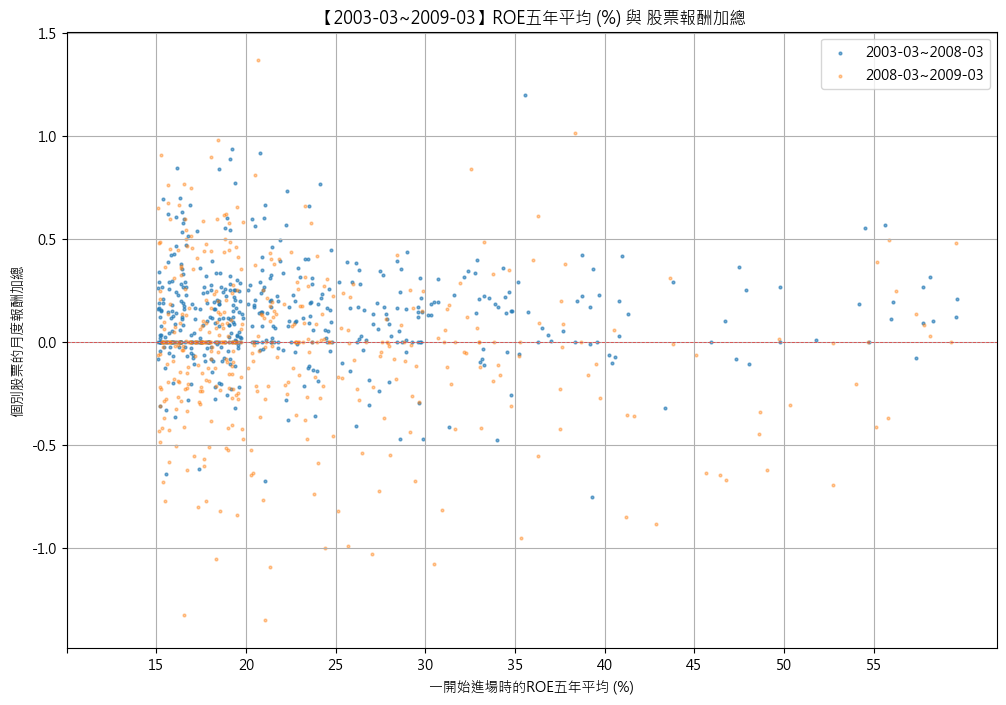

In [28]:
trades_cagr_analysis_split_returns(roe_15, roe_rol, 'ROE五年平均 (%)', N=0.1, 
                                       split_date='2008-03', start_date='2003-03', end_date='2009-03', data=data, remove=False, interval_range=(15, 55, 5), percentage=False)

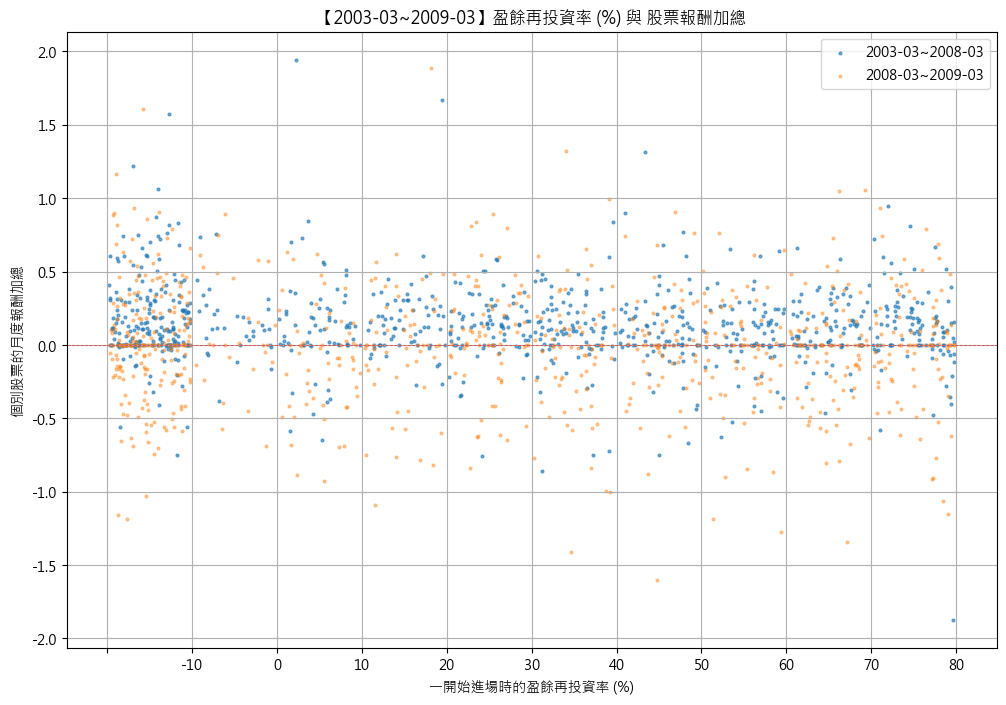

In [30]:
trades_cagr_analysis_split_returns(rr < 0.8, rr, '盈餘再投資率 (%)', N=0.1, 
                                       split_date='2008-03', start_date='2003-03', end_date='2009-03', data=data, remove=False, interval_range=(-10, 80, 10))

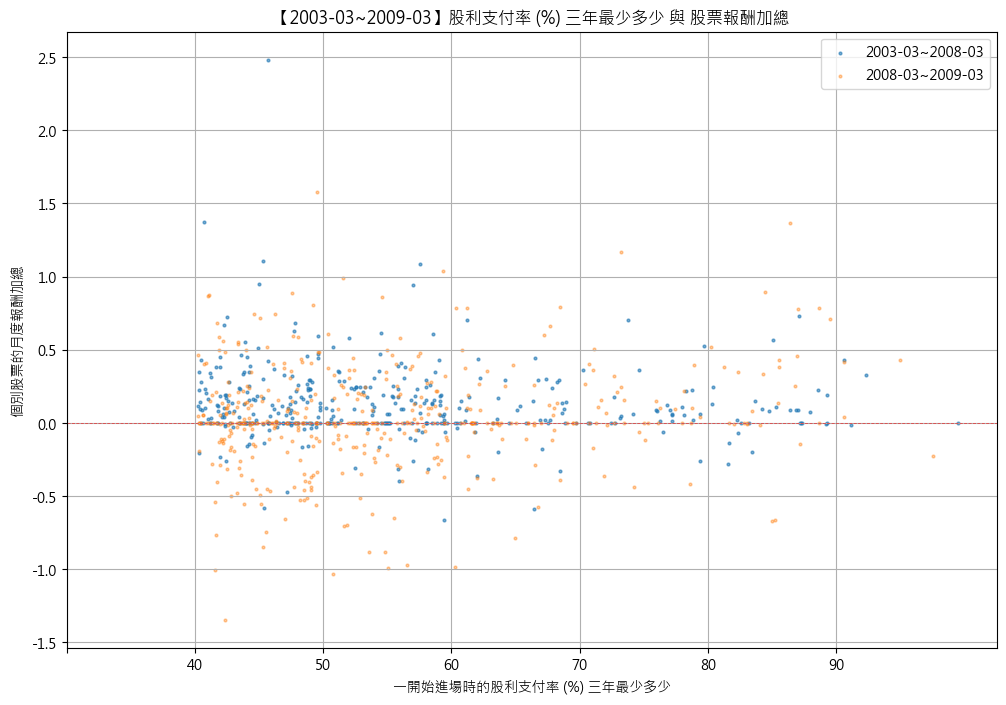

In [32]:
trades_cagr_analysis_split_returns(payout_ratio_cond, payout_ratio.rolling(3).min(), '股利支付率 (%) 三年最少多少', N=0.5, 
split_date='2008-03', start_date='2003-03', end_date='2009-03', data=data, remove=False, interval_range=(40, 90, 10), percentage=False)

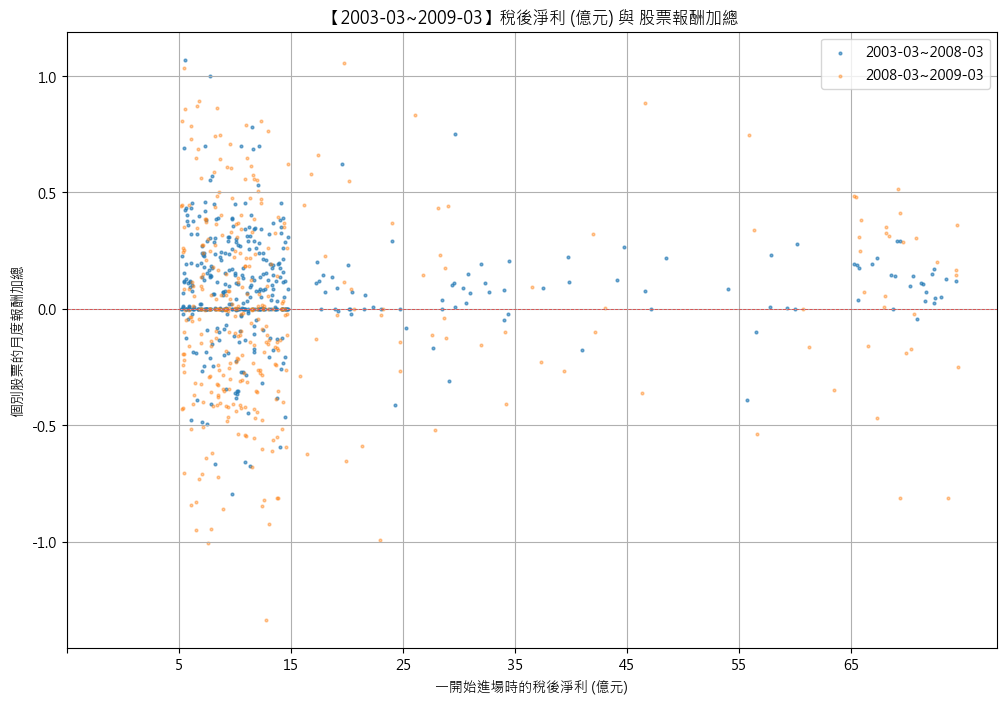

In [32]:
trades_cagr_analysis_split_returns(profit_cond, profit, '稅後淨利 (億元)', N=0.1, 
split_date='2008-03', start_date='2003-03', end_date='2009-03', data=data, remove=False,interval_range=(5, 65, 10),percentage=False)

---

## 台股布林通道

In [33]:
taiex_close = data.get('taiex:close')

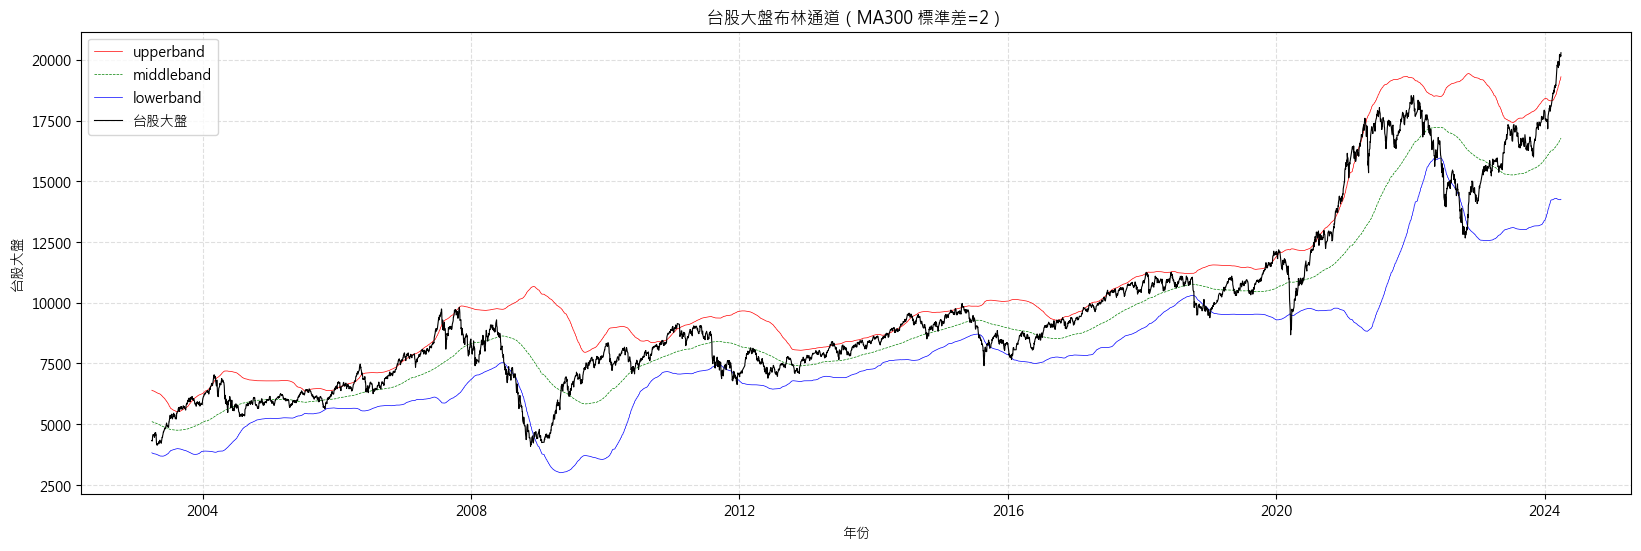

In [36]:
upperband, middleband, lowerband = talib.BBANDS(taiex_close.close, timeperiod=300, nbdevup=2.0, nbdevdn=2.0)


plt.figure(figsize=(20, 6))

plt.plot(upperband['2003-03-31':'2024-03-31'],
         label="upperband",color='r',
         linestyle='solid', linewidth=0.5)
plt.plot(middleband['2003-03-31':'2024-03-31'],
         label="middleband",color='g',linestyle='--', linewidth=0.5)
plt.plot(lowerband['2003-03-31':'2024-03-31'],
         label="lowerband",color='b',
         linestyle='solid', linewidth=0.5)
plt.plot(taiex_close['2003-03-31':'2024-03-31'],
         label="台股大盤",color='black', linewidth=0.8)



plt.title("台股大盤布林通道（MA300 標準差=2）") 
plt.xlabel("年份") 
plt.ylabel("台股大盤")

plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

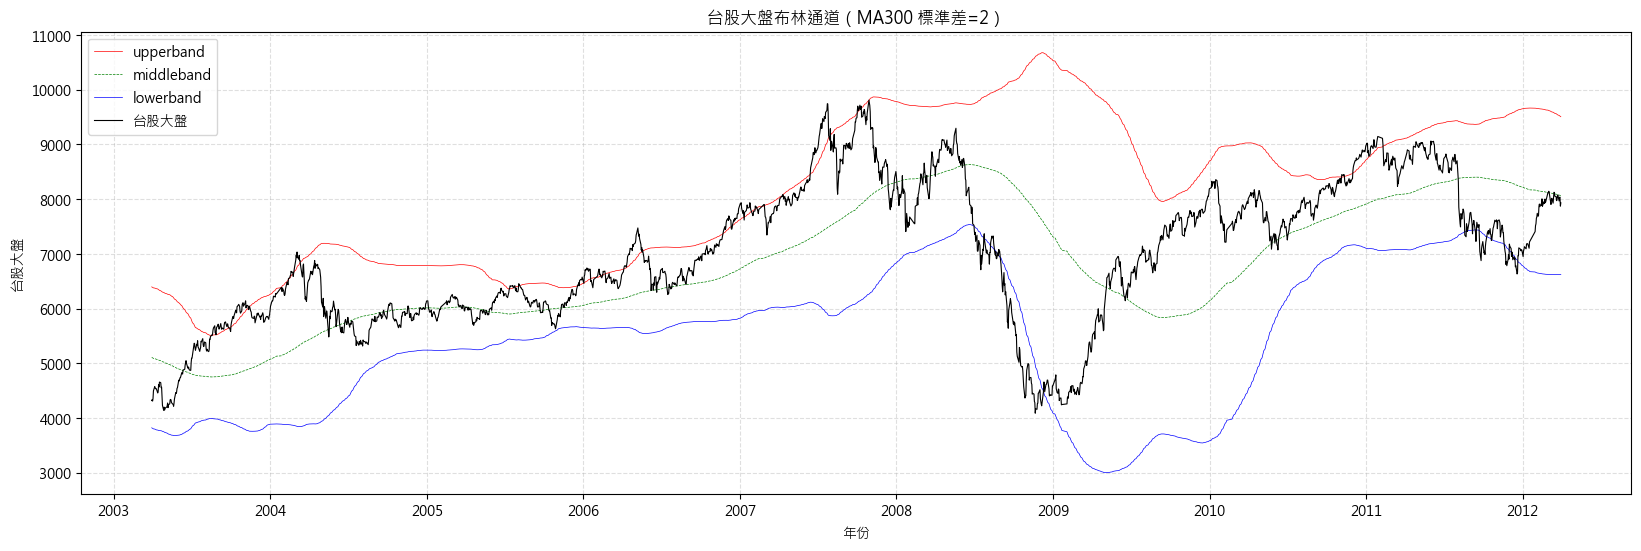

In [38]:
plt.figure(figsize=(20, 6))

plt.plot(upperband['2003-03-31':'2012-03-31'],
         label="upperband",color='r',
         linestyle='solid', linewidth=0.5)
plt.plot(middleband['2003-03-31':'2012-03-31'],
         label="middleband",color='g',linestyle='--', linewidth=0.5)
plt.plot(lowerband['2003-03-31':'2012-03-31'],
         label="lowerband",color='b',
         linestyle='solid', linewidth=0.5)
plt.plot(taiex_close['2003-03-31':'2012-03-31'],
         label="台股大盤",color='black', linewidth=0.8)



plt.title("台股大盤布林通道（MA300 標準差=2）") 
plt.xlabel("年份") 
plt.ylabel("台股大盤")

plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

---

In [22]:
orig_all_cond = roe_15 & rr_cond & payout_ratio_cond & profit_cond & hold_cond & listed

---

In [23]:
# 原始條件、無本益比進出場

rep_all_cond = backtest.sim(orig_all_cond[START_DATE:END_DATE], resample='M', data=data)
rep_all_cond.display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                    11.27%  50.25      -53.93%    41.18%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
1473     2003-04-01 2009-04-01     2003-03-31    2009-03-31  0.333333    1491   
1477     2005-04-01 2009-04-01     2005-03-31    2009-03-31  0.050000     991   
2002     2005-04-01 2009-04-01     2005-03-31    2009-03-31  0.050000     991   
2027     2007-05-02 2009-04-01     2007-04-30    2009-03-31  0.024390     476   
2029     2006-04-03 2009-04-01     2006-03-31    2009-03-31  0.029412     743   
...             ...        ...            ...           ...       ...     ...   
8046     2009-04-01        NaT     2009-03-31           NaT  0.018182    3813   
8072     2009-04-01        NaT     2009-03-31           NaT  0.018182    3813   
8924     2005-04-01        NaT     2005-03-31           NaT  0.050000    4804   
9917     2005-04-01        NaT     2005-03-31           NaT  0.050000    4804   
9930     2006-04-03        NaT     2006-03-31           NaT  0.029412    4556   

          entry_index  exit_index    return       mae      gmfe      bmfe  \
stock_id                                                                    
1473              819        2310 -0.259782 -0.358219  1.018494  1.018494   
1477             1319        2310  0.145771 -0.260041  2.106229  2.106229   
2002             1319        2310  0.100460 -0.210383  1.376140  0.015704   
2027             1834        2310 -0.643627 -0.745723  0.103093  0.103093   
2029             1567        2310  0.019550 -0.328110  0.530795  0.530795   
...               ...         ...       ...       ...       ...       ...   
8046             2310          -1  1.621605 -0.686212  9.153406  0.880004   
8072             2310          -1 -0.397489 -0.614251  0.528405  0.528405   
8924             1319          -1  2.776022 -0.601674  5.249710  0.879408   
9917             1319          -1  7.448426 -0.008209  8.097537  0.161979   
9930             1567          -1  7.618883 -0.011491  8.523685  0.000000   

               mdd   pdays    weight  next_weights  
stock_id                                            
1473     -0.682050  1315.0  0.000000      0.000000  
1477     -0.761782   838.0  0.000000      0.000000  
2002     -0.572777   757.0  0.000000      0.000000  
2027     -0.769487    42.0  0.000000      0.000000  
2029     -0.561084   503.0  0.000000      0.000000  
...            ...     ...       ...           ...  
8046     -0.833092  1725.0  0.018182      0.018182  
8072     -0.747613  1390.0  0.018182      0.018182  
8924     -0.788058  2887.0  0.018182      0.018182  
9917     -0.455122  4798.0  0.018182      0.018182  
9930     -0.467763  4551.0  0.018182      0.018182  

[73 rows x 16 columns]

In [24]:
# rep_all_cond.trades.sort_values('stock_id', ascending=True).to_csv('../2024_code/exp_data/rep_all_cond_trades_2.csv', encoding='cp950')

In [25]:
# rep_all_cond.plot_holding_period_return()

## 原始條件 + 有本益比進出場

### 每季本益比進出場

In [26]:
# (每季)本益比條件

pe_cond_entry = pe < 12
pe_cond_exit = pe > 30

In [27]:
orig_all_cond_and_pe = (orig_all_cond[START_DATE:END_DATE] & pe_cond_entry[START_DATE:END_DATE]).hold_until((~orig_all_cond[START_DATE:END_DATE]) | pe_cond_exit[START_DATE:END_DATE])

In [28]:
rep_all_cond_and_pe = backtest.sim(orig_all_cond_and_pe, resample='M', data=data)
rep_all_cond_and_pe.get_stats()

{'CAGR': 0.09662694373369773,
 'daily_sharpe': 52.19,
 'max_drawdown': -0.5629055197171287,
 'avg_drawdown': -0.0899355318436352,
 'win_ratio': 0.5151515151515151,
 'ytd': 0.23851206173152129}

In [29]:
# rep_all_cond_and_pe.plot_company_counts()

### **每月本益比進出場**

In [30]:
# 每日本益比resample成每月
daily_pe_resample = daily_pe.resample('M').last()

pe_cond_entry_daily = daily_pe_resample < 12
pe_cond_exit_daily = daily_pe_resample > 30

In [31]:
orig_all_cond_and_pe_daily = ((orig_all_cond[START_DATE:END_DATE] & pe_cond_entry_daily[START_DATE:END_DATE]).hold_until((~orig_all_cond[START_DATE:END_DATE]) | pe_cond_exit_daily[START_DATE:END_DATE]))

rep_all_cond_and_pe_daily = backtest.sim(orig_all_cond_and_pe_daily, resample='M', data=data)
rep_all_cond_and_pe_daily.display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                     11.4%  49.22      -55.18%    42.86%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
1303     2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.026316     249   
1473     2003-04-01 2009-04-01     2003-03-31    2009-03-31  0.500000    1491   
1477     2005-04-01 2009-04-01     2005-03-31    2009-03-31  0.071429     991   
2002     2005-04-01 2009-04-01     2005-03-31    2009-03-31  0.071429     991   
2027     2007-05-02 2009-04-01     2007-04-30    2009-03-31  0.028571     476   
...             ...        ...            ...           ...       ...     ...   
8046     2009-04-01        NaT     2009-03-31           NaT  0.021739    3813   
8072     2009-04-01        NaT     2009-03-31           NaT  0.021739    3813   
8924     2005-04-01        NaT     2005-03-31           NaT  0.071429    4804   
9917     2008-10-01        NaT     2008-09-30           NaT  0.019608    3935   
9930     2006-04-03        NaT     2006-03-31           NaT  0.037037    4556   

          entry_index  exit_index    return       mae      gmfe      bmfe  \
stock_id                                                                    
1303             2061        2310 -0.411847 -0.522974  0.043362  0.043362   
1473              819        2310 -0.259782 -0.358219  1.018494  1.018494   
1477             1319        2310  0.145771 -0.260041  2.106229  2.106229   
2002             1319        2310  0.100460 -0.210383  1.376140  0.015704   
2027             1834        2310 -0.643627 -0.745723  0.103093  0.103093   
...               ...         ...       ...       ...       ...       ...   
8046             2310          -1  1.621605 -0.686212  9.153406  0.880004   
8072             2310          -1 -0.397489 -0.614251  0.528405  0.528405   
8924             1319          -1  2.776022 -0.601674  5.249710  0.879408   
9917             2188          -1  5.448780 -0.234411  5.945744  0.064518   
9930             1567          -1  7.618883 -0.011491  8.523685  0.000000   

               mdd   pdays    weight  next_weights  
stock_id                                            
1303     -0.542799    21.0  0.000000      0.000000  
1473     -0.682050  1315.0  0.000000      0.000000  
1477     -0.761782   838.0  0.000000      0.000000  
2002     -0.572777   757.0  0.000000      0.000000  
2027     -0.769487    42.0  0.000000      0.000000  
...            ...     ...       ...           ...  
8046     -0.833092  1725.0  0.021739      0.021739  
8072     -0.747613  1390.0  0.021739      0.021739  
8924     -0.788058  2887.0  0.021739      0.021739  
9917     -0.280811  3824.0  0.021739      0.021739  
9930     -0.467763  4551.0  0.021739      0.021739  

[65 rows x 16 columns]

In [32]:
all_cond_pos_ret, all_cond_neg_ret = rep_all_cond_and_pe_daily.calc_returns_contrib(5)

---

## 綜合比較入選股數變化

In [33]:
all_cond_reps = {}

all_cond_reps['原始條件_無本益比進出場_2003~2009'] = orig_all_cond[START_DATE:END_DATE]
all_cond_reps['原始條件_每季本益比_2003~2009'] = orig_all_cond_and_pe[START_DATE:END_DATE]
all_cond_reps['原始條件_每日本益比_2003~2009'] = orig_all_cond_and_pe_daily[START_DATE:END_DATE]

all_cond_reps['原始條件_無本益比進出場_2009~2024'] = orig_all_cond['2009-3':'2024']
all_cond_reps['原始條件_每季本益比_2009~2024'] = (orig_all_cond['2009-3':'2024'] & pe_cond_entry['2009-3':'2024']).hold_until((~orig_all_cond['2009-3':'2024']) | pe_cond_exit['2009-3':'2024'])
all_cond_reps['原始條件_每日本益比_2009~2024'] = ((orig_all_cond['2009-3':'2024'] & pe_cond_entry_daily['2009-3':'2024']).hold_until((~orig_all_cond['2009-3':'2024']) | pe_cond_exit_daily['2009-3':'2024']))


rep_collecs = sim_conditions(all_cond_reps, resample='M', data=data)


# all_cond_reps_2003_09 = {}

# all_cond_reps_2003_09['原始條件_無本益比進出場_2003_09'] = orig_all_cond[START_DATE:END_DATE]
# all_cond_reps_2003_09['原始條件_每季本益比_2003_09'] = orig_all_cond_and_pe[START_DATE:END_DATE]
# all_cond_reps_2003_09['原始條件_每日本益比_2003_09'] = orig_all_cond_and_pe_daily[START_DATE:END_DATE]

# all_cond_reps_2009_24 = {}

# all_cond_reps_2009_24['原始條件_無本益比進出場_2009_24'] = orig_all_cond[2009:2024]
# all_cond_reps_2009_24['原始條件_每季本益比_2009_24'] = orig_all_cond_and_pe[2009:2024]
# all_cond_reps_2009_24['原始條件_每日本益比_2009_24'] = orig_all_cond_and_pe_daily[2009:2024]


# rep_collecs_2003_09 = sim_conditions(all_cond_reps_2003_09, resample='M', data=data)
# rep_collecs_2009_24 = sim_conditions(all_cond_reps_2009_24, resample='M', data=data)


Backtesting progress: 100%|██████████| 6/6 [00:18<00:00,  3.15s/condition]


In [34]:
# rep_collecs.plot_creturns()

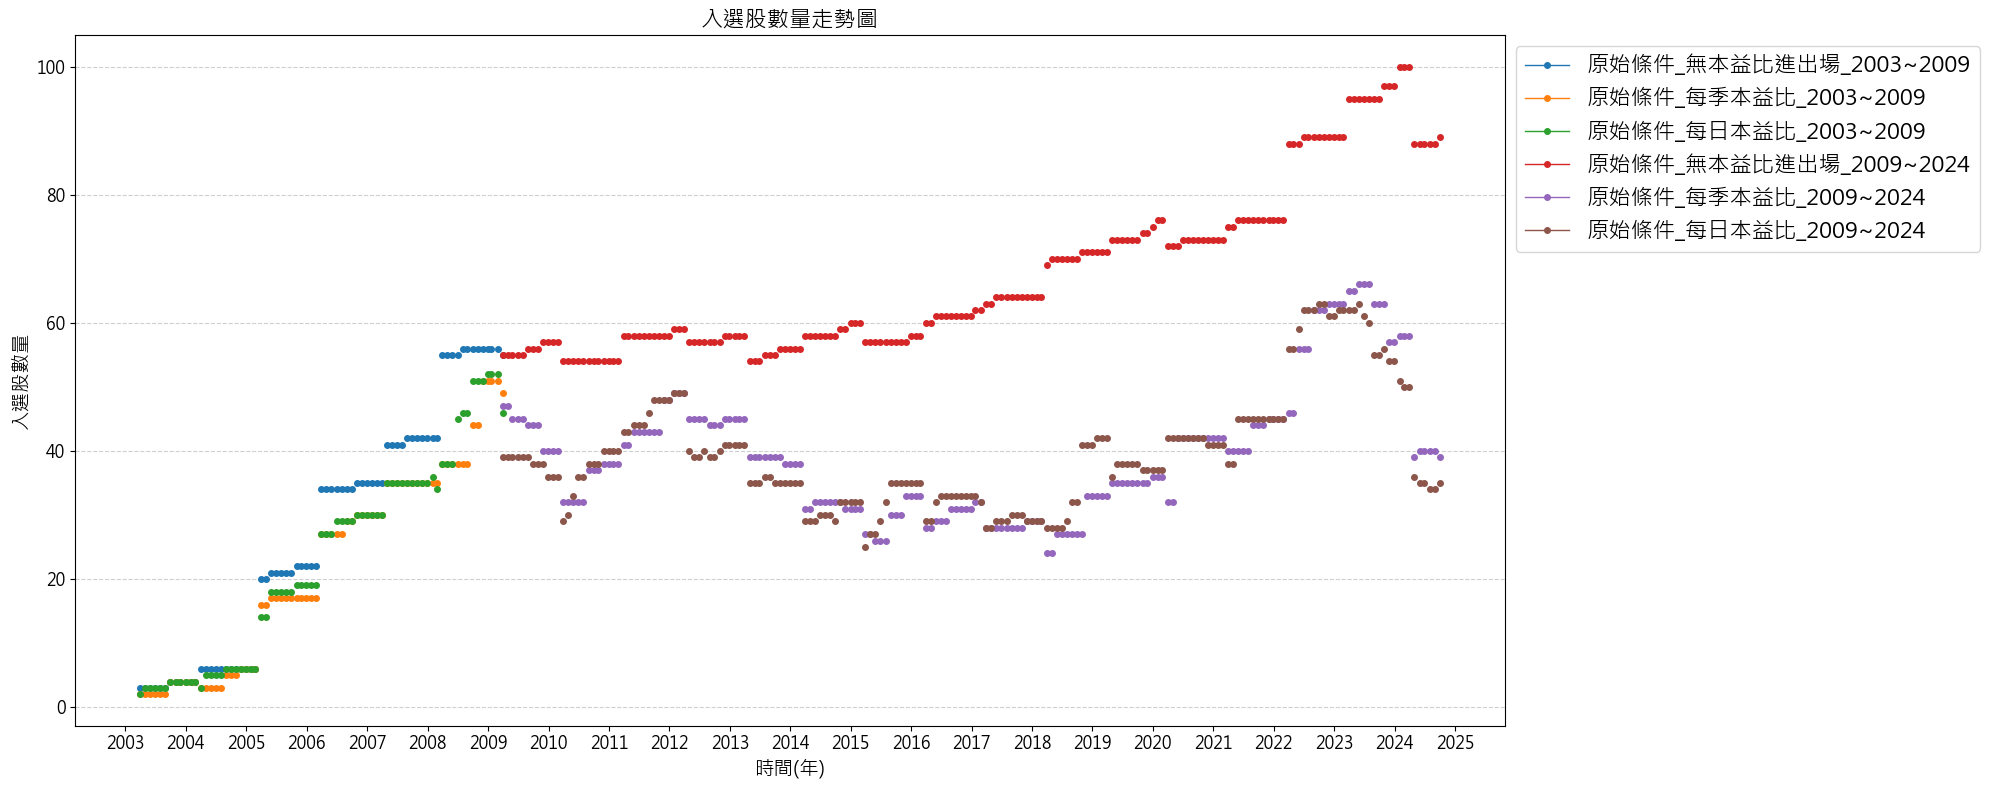

In [35]:
rep_collecs.plot_reps_stock_counts()

In [36]:
rep_collecs.plot_stats()

In [37]:
rep_collecs.selected_stock_count_analysis()

CAGR (%)  MDD (%)  入選股數平均   中位數   25%   75%   Min  \
Strategy                                                                    
原始條件_每季本益比_2009~2024       14.80   -30.48   39.70  39.0  32.0  45.0  24.0   
原始條件_每日本益比_2009~2024       14.72   -30.55   39.64  38.0  33.0  43.0  25.0   
原始條件_無本益比進出場_2009~2024     13.08   -29.66   67.50  61.0  57.0  74.0  54.0   
原始條件_每日本益比_2003~2009       11.40   -55.18   23.11  27.0   6.0  35.0   2.0   
原始條件_無本益比進出場_2003~2009     11.27   -53.93   27.37  34.0   6.0  42.0   3.0   
原始條件_每季本益比_2003~2009        9.66   -56.29   22.18  27.0   5.0  35.0   2.0   

                          Max  
Strategy                       
原始條件_每季本益比_2009~2024     66.0  
原始條件_每日本益比_2009~2024     63.0  
原始條件_無本益比進出場_2009~2024  100.0  
原始條件_每日本益比_2003~2009     52.0  
原始條件_無本益比進出場_2003~2009   56.0  
原始條件_每季本益比_2003~2009     51.0

In [38]:
# rep_collecs.reports['原始條件_每日本益比_2009~2024'].display()

In [39]:
# rep_collecs.reports['原始條件_無本益比進出場'].trades.sort_values('period', ascending=False)

---

## ROE 參數最佳化 + 有無本益比進出場

In [40]:
pe_cond_entry = daily_pe_resample < 12
pe_cond_exit = daily_pe_resample > 30



roe_value_pe = {}
no_roe_conds = rr_cond & profit_cond & hold_cond & listed & payout_ratio_cond

for i in range(10, 26, 5): # 大於 10~25%
    for n in range(3, 6): # 3, 4, 5年平均
        
        roe_rolling = roe.rolling(n).mean()
        roe_cond_opt = (roe_rolling > i) # [START_DATE:END_DATE]

        roe_value_pe[f'roe_{n}y_{i} 無本益比進出場'] = (roe_cond_opt & no_roe_conds)[START_DATE:END_DATE]

        roe_value_pe[f'roe_{n}y_{i} 有本益比進出場'] = ((roe_cond_opt[START_DATE:END_DATE] &  no_roe_conds[START_DATE:END_DATE] & pe_cond_entry[START_DATE:END_DATE]).hold_until((~(roe_cond_opt[START_DATE:END_DATE] &  no_roe_conds[START_DATE:END_DATE])) | pe_cond_exit[START_DATE:END_DATE]))

        # roe_value_pe[f'roe_{n}y_{i}'] = ((roe_cond_opt[START_DATE:END_DATE] &  no_roe_conds[START_DATE:END_DATE] & pe_cond_entry[START_DATE:END_DATE]).hold_until((~(roe_cond_opt[START_DATE:END_DATE] &  no_roe_conds[START_DATE:END_DATE])) | pe_cond_exit[START_DATE:END_DATE]))

        
roe_pe_collection = sim_conditions(roe_value_pe, resample='M', data=data)


Backtesting progress: 100%|██████████| 24/24 [01:08<00:00,  2.87s/condition]


In [41]:
roe_pe_collection.selected_stock_count_analysis()

CAGR (%)  MDD (%)  入選股數平均   中位數   25%    75%  Min   Max
Strategy                                                                  
roe_3y_20 有本益比進出場     14.09   -56.39   14.50  17.0   2.0  22.25  1.0  35.0
roe_3y_20 無本益比進出場     13.11   -55.19   16.96  23.0   2.0  28.00  1.0  36.0
roe_5y_10 無本益比進出場     12.83   -52.56   35.33  45.0   9.0  47.00  6.0  71.0
roe_5y_20 無本益比進出場     12.78   -55.40   14.08  14.0   3.0  23.00  2.0  34.0
roe_3y_10 無本益比進出場     12.66   -52.63   37.58  47.0  12.0  53.00  6.0  74.0
roe_3y_10 有本益比進出場     12.54   -53.08   32.07  38.0  12.0  44.00  4.0  67.0
roe_4y_20 有本益比進出場     12.51   -58.90   13.04  14.0   2.0  21.00  1.0  33.0
roe_4y_20 無本益比進出場     12.34   -55.01   15.25  17.0   2.0  27.00  1.0  36.0
roe_3y_15 無本益比進出場     12.34   -55.15   28.71  39.0   6.0  43.00  3.0  54.0
roe_5y_10 有本益比進出場     11.94   -53.87   30.56  36.0   9.0  42.00  4.0  64.0
roe_4y_10 有本益比進出場     11.93   -53.50   31.23  36.0  11.0  42.00  4.0  66.0
roe_4y_10 無本益比進出場     11.72   -53.10   36.30  45.0  11.0  50.00  6.0  72.0
roe_3y_15 有本益比進出場     11.63   -56.50   24.58  31.0   6.0  36.00  2.0  51.0
roe_4y_15 有本益比進出場     11.55   -55.88   23.42  28.0   6.0  36.00  1.0  53.0
roe_5y_20 有本益比進出場     11.54   -58.04   12.00  11.0   3.0  19.00  1.0  31.0
roe_5y_15 有本益比進出場     11.40   -55.18   23.11  27.0   6.0  35.00  2.0  52.0
roe_5y_15 無本益比進出場     11.27   -53.93   27.37  34.0   6.0  42.00  3.0  56.0
roe_4y_15 無本益比進出場     11.01   -54.27   27.64  35.0   6.0  44.00  2.0  56.0
roe_4y_25 有本益比進出場     10.43   -62.27   10.07  11.0   4.0  15.00  1.0  22.0
roe_4y_25 無本益比進出場      9.05   -64.73   11.08  11.0   5.0  16.00  1.0  22.0
roe_3y_25 有本益比進出場      6.83   -60.75   13.18  12.0   9.0  16.00  4.0  23.0
roe_5y_25 有本益比進出場      6.35   -61.87   12.20  10.0   8.0  15.00  5.0  21.0
roe_3y_25 無本益比進出場      6.17   -61.76   14.39  12.0  11.0  21.00  6.0  23.0
roe_5y_25 無本益比進出場      5.70   -62.73   13.29  10.0  10.0  19.00  7.0  21.0

In [42]:
# roe.rolling(5).mean()[['1723']]

In [43]:
# roe_pe_collection.reports['roe_3y_20'].display()

In [44]:
roe_value_cond = {}
no_roe_conds = rr_cond & profit_cond & hold_cond & listed & payout_ratio_cond

for i in range(10, 26, 5): # 大於 10~25%
    for n in range(3, 6): # 3, 4, 5年平均
        
        roe_rolling = roe.rolling(n).mean()
        roe_cond_opt = (roe_rolling > i) # [START_DATE:END_DATE]

        # roe_value_cond[f'roe_{n}y_{i} 無本益比進出場'] = (roe_cond_opt & no_roe_conds)[START_DATE:END_DATE]

        # roe_value_cond[f'roe_{n}y_{i} 有本益比進出場'] = ((roe_cond_opt &  no_roe_conds & pe_cond_entry).hold_until((~(roe_cond_opt &  no_roe_conds)) | pe_cond_exit))[START_DATE:END_DATE]


        roe_value_cond[f'roe_{n}y_{i}_2003~2009'] = ((roe_cond_opt[START_DATE:END_DATE] &  no_roe_conds[START_DATE:END_DATE] & pe_cond_entry[START_DATE:END_DATE]).hold_until((~(roe_cond_opt[START_DATE:END_DATE] &  no_roe_conds[START_DATE:END_DATE])) | pe_cond_exit[START_DATE:END_DATE]))
        roe_value_cond[f'roe_{n}y_{i}_2009~2024'] = ((roe_cond_opt['2009-3':'2024'] &  no_roe_conds['2009-3':'2024'] & pe_cond_entry['2009-3':'2024']).hold_until((~(roe_cond_opt['2009-3':'2024'] &  no_roe_conds['2009-3':'2024'])) | pe_cond_exit['2009-3':'2024']))
        
roe_collection = sim_conditions(roe_value_cond, resample='M', data=data)


Backtesting progress: 100%|██████████| 24/24 [01:01<00:00,  2.58s/condition]


In [45]:
roe_collection.selected_stock_count_analysis()

CAGR (%)  MDD (%)  入選股數平均   中位數   25%    75%   Min    Max
Strategy                                                                      
roe_4y_15_2009~2024     15.33   -30.85   39.39  37.0  32.0  42.00  23.0   66.0
roe_4y_10_2009~2024     15.10   -29.47   64.37  60.0  54.5  73.00  34.0  107.0
roe_5y_10_2009~2024     15.06   -29.83   63.83  59.0  53.0  74.00  34.0  104.0
roe_3y_10_2009~2024     14.95   -29.62   64.12  60.0  52.0  73.00  33.0  113.0
roe_5y_15_2009~2024     14.72   -30.55   39.64  38.0  33.0  43.00  25.0   63.0
roe_3y_15_2009~2024     14.23   -30.59   39.64  38.0  33.0  42.00  25.0   69.0
roe_3y_20_2003~2009     14.09   -56.39   14.50  17.0   2.0  22.25   1.0   35.0
roe_3y_10_2003~2009     12.54   -53.08   32.07  38.0  12.0  44.00   4.0   67.0
roe_4y_20_2003~2009     12.51   -58.90   13.04  14.0   2.0  21.00   1.0   33.0
roe_3y_20_2009~2024     12.45   -31.64   20.96  20.0  15.0  25.00   9.0   39.0
roe_4y_20_2009~2024     12.32   -32.57   20.45  19.0  15.0  26.00  11.0   33.0
roe_5y_10_2003~2009     11.94   -53.87   30.56  36.0   9.0  42.00   4.0   64.0
roe_4y_10_2003~2009     11.93   -53.50   31.23  36.0  11.0  42.00   4.0   66.0
roe_3y_15_2003~2009     11.63   -56.50   24.58  31.0   6.0  36.00   2.0   51.0
roe_4y_15_2003~2009     11.55   -55.88   23.42  28.0   6.0  36.00   1.0   53.0
roe_5y_20_2003~2009     11.54   -58.04   12.00  11.0   3.0  19.00   1.0   31.0
roe_5y_15_2003~2009     11.40   -55.18   23.11  27.0   6.0  35.00   2.0   52.0
roe_5y_20_2009~2024     10.95   -32.57   20.21  19.0  16.0  24.50   9.0   33.0
roe_4y_25_2003~2009     10.43   -62.27   10.07  11.0   4.0  15.00   1.0   22.0
roe_3y_25_2009~2024      8.81   -37.39    9.85   8.0   6.0  14.00   2.0   20.0
roe_5y_25_2009~2024      7.91   -38.04    9.32   9.0   5.0  12.00   3.0   21.0
roe_3y_25_2003~2009      6.83   -60.75   13.18  12.0   9.0  16.00   4.0   23.0
roe_4y_25_2009~2024      6.40   -45.75    9.33   9.0   5.0  13.00   3.0   19.0
roe_5y_25_2003~2009      6.35   -61.87   12.20  10.0   8.0  15.00   5.0   21.0

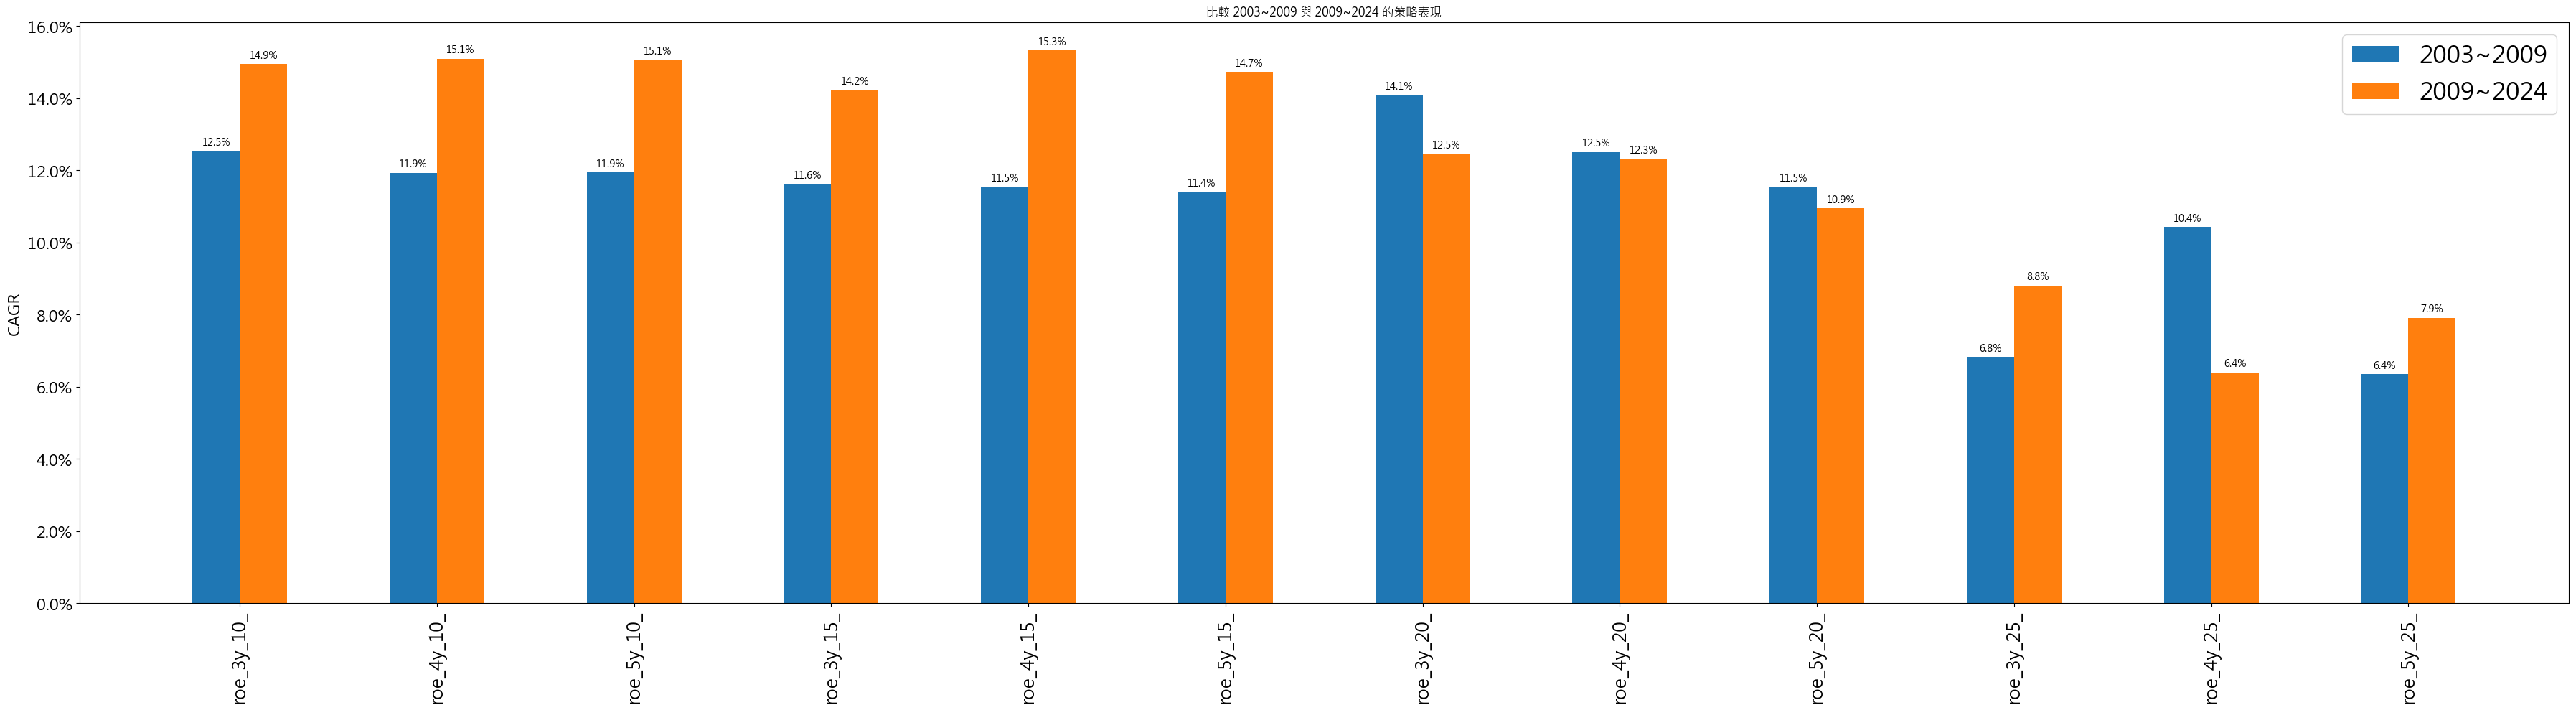

In [46]:
roe_collection.compare_strat_perform('2003~2009','2009~2024')

In [47]:
roe_collection.reports['roe_3y_20_2003~2009'].display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                    14.09%  47.87      -56.39%    43.33%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
1303     2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.043478     249   
1477     2005-04-01 2009-04-01     2005-03-31    2009-03-31  0.125000     991   
2002     2005-04-01 2009-04-01     2005-03-31    2009-03-31  0.125000     991   
2006     2008-07-01 2009-04-01     2008-06-30    2009-03-31  0.035714     186   
2027     2007-05-02 2009-04-01     2007-04-30    2009-03-31  0.045455     476   
3010     2007-05-02 2009-04-01     2007-04-30    2009-03-31  0.045455     476   
3014     2008-10-01 2009-04-01     2008-09-30    2009-03-31  0.030303     122   
6188     2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.043478     249   
6203     2008-07-01 2009-04-01     2008-06-30    2009-03-31  0.035714     186   
6206     2008-07-01 2009-04-01     2008-06-30    2009-03-31  0.035714     186   
6277     2005-11-01 2009-04-01     2005-10-31    2009-03-31  0.090909     845   
6281     2008-07-01 2009-04-01     2008-06-30    2009-03-31  0.035714     186   
6505     2006-04-03 2009-04-01     2006-03-31    2009-03-31  0.058824     743   
9921     2008-11-03 2009-04-01     2008-10-31    2009-03-31  0.029412     100   
9927     2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.043478     249   
1565     2009-04-01        NaT     2009-03-31           NaT  0.034483    3813   
1723     2003-05-02        NaT     2003-04-30           NaT  1.000000    5282   
2103     2007-05-02        NaT     2007-04-30           NaT  0.045455    4289   
2360     2009-04-01        NaT     2009-03-31           NaT  0.034483    3813   
2365     2008-04-01        NaT     2008-03-31           NaT  0.043478    4062   
2374     2008-04-01        NaT     2008-03-31           NaT  0.043478    4062   
2395     2009-04-01        NaT     2009-03-31           NaT  0.034483    3813   
2450     2009-04-01        NaT     2009-03-31           NaT  0.034483    3813   
2451     2005-06-01        NaT     2005-05-31           NaT  0.100000    4763   
2495     2007-05-02        NaT     2007-04-30           NaT  0.045455    4289   
2498     2008-10-01        NaT     2008-09-30           NaT  0.030303    3935   
2548     2006-04-03        NaT     2006-03-31           NaT  0.058824    4556   
2606     2005-04-01        NaT     2005-03-31           NaT  0.125000    4804   
2617     2009-04-01        NaT     2009-03-31           NaT  0.034483    3813   
3034     2006-07-03        NaT     2006-06-30           NaT  0.050000    4494   
3035     2008-07-01        NaT     2008-06-30           NaT  0.035714    3999   
3293     2008-10-01        NaT     2008-09-30           NaT  0.030303    3935   
3356     2008-10-01        NaT     2008-09-30           NaT  0.030303    3935   
5203     2009-01-05        NaT     2008-12-31           NaT  0.028571    3870   
5471     2006-04-03        NaT     2006-03-31           NaT  0.058824    4556   
5508     2007-05-02        NaT     2007-04-30           NaT  0.045455    4289   
5534     2009-04-01        NaT     2009-03-31           NaT  0.034483    3813   
6115     2009-04-01        NaT     2009-03-31           NaT  0.034483    3813   
6121     2008-08-01        NaT     2008-07-31           NaT  0.034483    3977   
6202     2006-11-01        NaT     2006-10-31           NaT  0.047619    4409   
8046     2009-04-01        NaT     2009-03-31           NaT  0.034483    3813   
8072     2009-04-01        NaT     2009-03-31           NaT  0.034483    3813   
8924     2005-04-01        NaT     2005-03-31           NaT  0.125000    4804   
9930     2007-05-02        NaT     2007-04-30           NaT  0.045455    4289   

          entry_index  exit_index     return       mae       gmfe      bmfe  \
stock_id                                                                      
1303             2061        2310  -0.411847 -0.522974   0.043362  0.043362   
1477             1319        2310   0.145771 

In [48]:
# roe_collection.plot_roe_cagr()

---

---

## 比較有無某項條件績效差異

In [88]:
import itertools

# 定義所有 DataFrame 名稱及其對應的中文名稱
dataframes = {
    'roe_15': roe_15,  # 假設這些DataFrame已經存在
    'rr_cond': rr_cond,
    'payout_ratio_cond': payout_ratio_cond,
    'profit_cond': profit_cond,
    'hold_cond': hold_cond,
    'listed': listed
}

# 定義 DataFrame 對應的中文名稱
dataframe_names = {
    'roe_15': 'ROE五年平均',
    'rr_cond': '盈再率',
    'payout_ratio_cond': '配息率',
    'profit_cond': '稅後淨利',
    'hold_cond': '董監持股',
    'listed': '上市櫃滿兩年'
}


# 用於儲存組合結果
compare_conds_strat = {}

# 產生不同長度的組合，從1到6
counter = 1
for r in range(1, len(dataframes) + 1):
    for combination in itertools.combinations(dataframes.keys(), r):
        # 計算DataFrame間的 AND 運算
        combined_signal = dataframes[combination[0]]
        for df_name in combination[1:]:
            combined_signal &= dataframes[df_name]

        # 限制日期區間
        combined_signal = CustomDataFrame(combined_signal)
        combined_signal = combined_signal[START_DATE:END_DATE]

        # 使用組合的中文名稱生成key_name
        key_name = "+".join([dataframe_names[df] for df in combination])

        # 將計算結果儲存到字典
        compare_conds_strat[key_name] = combined_signal
        counter += 1

# # 顯示字典中的結果名稱
# for name, expression in compare_conds_strat.items():
#     print(f"{name}:")
#     print(expression)


---

### 分成有無進出場條件兩組

In [89]:
pe_cond_entry_daily = (daily_pe_resample < 12)[START_DATE:END_DATE]
pe_cond_exit_daily = (daily_pe_resample > 30)[START_DATE:END_DATE]


compare_conds_strat['原始條件_有本益比進出場'] = orig_all_cond_and_pe_daily[START_DATE:END_DATE]
compare_conds_strat['原始條件_無本益比進出場'] = orig_all_cond[START_DATE:END_DATE]







compare_strat_collecs = sim_conditions(compare_conds_strat, resample='M', data=data)
# compare_strat_collecs.plot_stats('heatmap')

Backtesting progress: 100%|██████████| 65/65 [09:41<00:00,  8.94s/condition]


In [90]:
compare_strat_collecs.selected_stock_count_analysis()

CAGR (%)  MDD (%)  入選股數平均    中位數    25%    75%  \
Strategy                                                                   
盈再率+配息率+稅後淨利+董監持股+上市櫃滿兩年     13.35   -51.90   40.18   50.0   14.0   55.0   
盈再率+配息率+稅後淨利+上市櫃滿兩年          13.22   -54.18   48.18   59.0   14.0   69.0   
盈再率+配息率+稅後淨利+董監持股            12.33   -52.65   42.96   51.0   15.0   60.0   
盈再率+配息率+稅後淨利                 12.27   -54.31   51.29   60.0   15.0   74.0   
原始條件_有本益比進出場                 11.40   -55.18   23.11   27.0    6.0   35.0   
...                            ...      ...     ...    ...    ...    ...   
ROE五年平均+配息率                   5.11   -58.90   94.63  106.0   33.0  153.0   
ROE五年平均+盈再率+上市櫃滿兩年            5.08   -63.98  108.19  119.0   55.0  164.0   
ROE五年平均+董監持股                  4.71   -61.21  309.81  305.0  282.0  346.0   
ROE五年平均                       4.71   -61.88  329.95  325.0  293.0  375.0   
ROE五年平均+配息率+上市櫃滿兩年            4.62   -58.92   77.74   84.0   23.0  126.0   

                            Min    Max  
Strategy                                
盈再率+配息率+稅後淨利+董監持股+上市櫃滿兩年    7.0   78.0  
盈再率+配息率+稅後淨利+上市櫃滿兩年         7.0   97.0  
盈再率+配息率+稅後淨利+董監持股           8.0   83.0  
盈再率+配息率+稅後淨利                8.0  103.0  
原始條件_有本益比進出場                2.0   52.0  
...                         ...    ...  
ROE五年平均+配息率                13.0  190.0  
ROE五年平均+盈再率+上市櫃滿兩年         21.0  176.0  
ROE五年平均+董監持股              247.0  375.0  
ROE五年平均                   255.0  415.0  
ROE五年平均+配息率+上市櫃滿兩年          6.0  164.0  

[65 rows x 8 columns]

In [ ]:
# compare_df_1 = compare_strat_collecs.selected_stock_count_analysis()
# compare_df_1.to_csv('../2024_code/performance_file/TW/所有排列組合條件_2003-09_無本益比進出場.csv', encoding='cp950')

In [95]:
# 用於儲存組合結果
compare_conds_strat_PE={}

# 產生不同長度的組合，從1到6
counter = 1
for r in range(1, len(dataframes) + 1):
    for combination in itertools.combinations(dataframes.keys(), r):
        # 計算DataFrame間的 AND 運算
        combined_signal = dataframes[combination[0]]
        for df_name in combination[1:]:
            combined_signal &= dataframes[df_name]

        # 限制日期區間
        combined_signal = CustomDataFrame(combined_signal)
        combined_signal = (combined_signal[START_DATE:END_DATE] & pe_cond_entry_daily[START_DATE:END_DATE]).hold_until((~combined_signal[START_DATE:END_DATE]) | pe_cond_exit_daily[START_DATE:END_DATE])

        # 使用組合的中文名稱生成key_name
        key_name = "+".join([dataframe_names[df] for df in combination])

        # 將計算結果儲存到字典
        compare_conds_strat_PE[key_name] = combined_signal
        counter += 1


compare_strat_collecs_PE = sim_conditions(compare_conds_strat_PE, resample='M', data=data)

Backtesting progress: 100%|██████████| 63/63 [13:10<00:00, 12.54s/condition]


In [96]:
compare_strat_collecs_PE.selected_stock_count_analysis()

CAGR (%)  MDD (%)  入選股數平均    中位數    25%    75%  \
Strategy                                                                   
盈再率+配息率+稅後淨利+上市櫃滿兩年          13.78   -54.32   40.04   46.0   13.0   55.0   
盈再率+配息率+稅後淨利                 13.71   -54.25   42.36   47.0   13.0   56.0   
盈再率+配息率+稅後淨利+董監持股+上市櫃滿兩年     13.48   -53.45   33.71   41.0   13.0   47.0   
盈再率+配息率+稅後淨利+董監持股            13.41   -53.88   35.70   42.0   13.0   47.0   
配息率+稅後淨利+董監持股+上市櫃滿兩年         12.28   -53.78   55.38   63.0   24.0   71.0   
...                            ...      ...     ...    ...    ...    ...   
ROE五年平均+董監持股                  5.32   -63.58  215.10  223.0  199.0  236.0   
ROE五年平均+上市櫃滿兩年                4.75   -61.60  143.81  149.0   92.0  178.0   
ROE五年平均+董監持股+上市櫃滿兩年           4.70   -61.22  130.26  140.0   84.0  165.0   
ROE五年平均+盈再率+董監持股+上市櫃滿兩年       4.21   -61.58   81.04   86.0   45.0  113.0   
ROE五年平均+盈再率+上市櫃滿兩年            4.08   -62.11   87.99   95.0   46.0  121.0   

                           Min    Max  
Strategy                               
盈再率+配息率+稅後淨利+上市櫃滿兩年        4.0   86.0  
盈再率+配息率+稅後淨利               5.0   92.0  
盈再率+配息率+稅後淨利+董監持股+上市櫃滿兩年   4.0   69.0  
盈再率+配息率+稅後淨利+董監持股          5.0   74.0  
配息率+稅後淨利+董監持股+上市櫃滿兩年       6.0  115.0  
...                        ...    ...  
ROE五年平均+董監持股              92.0  311.0  
ROE五年平均+上市櫃滿兩年            23.0  259.0  
ROE五年平均+董監持股+上市櫃滿兩年       23.0  226.0  
ROE五年平均+盈再率+董監持股+上市櫃滿兩年   13.0  139.0  
ROE五年平均+盈再率+上市櫃滿兩年        13.0  158.0  

[63 rows x 8 columns]

In [97]:
compare_df_2 = compare_strat_collecs_PE.selected_stock_count_analysis()
compare_df_2.to_csv('../2024_code/performance_file/TW/所有排列組合條件_2003-09_有本益比進出場.csv', encoding='cp950')

In [98]:
compare_strat_collecs_PE.reports['盈再率+配息率+董監持股+上市櫃滿兩年'].display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                    11.15%  54.19      -53.04%    60.32%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
1101     2006-04-03 2009-04-01     2006-03-31    2009-03-31  0.011236     743   
1219     2008-10-01 2009-04-01     2008-09-30    2009-03-31  0.006061     122   
1303     2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.007634     249   
1307     2008-02-01 2009-04-01     2008-01-31    2009-03-31  0.008264     284   
1325     2008-05-02 2009-04-01     2008-04-30    2009-03-31  0.007463     228   
...             ...        ...            ...           ...       ...     ...   
9925     2005-04-01        NaT     2005-03-31           NaT  0.014493    4804   
9926     2005-04-01        NaT     2005-03-31           NaT  0.014493    4804   
9930     2006-04-03        NaT     2006-03-31           NaT  0.011236    4556   
9933     2008-07-01        NaT     2008-06-30           NaT  0.006803    3999   
9942     2007-05-02        NaT     2007-04-30           NaT  0.009346    4289   

          entry_index  exit_index     return       mae       gmfe      bmfe  \
stock_id                                                                      
1101             1567        2310   0.437894 -0.268313   1.807116  1.807116   
1219             2188        2310   0.200104 -0.168030   0.268293  0.063690   
1303             2061        2310  -0.411847 -0.522974   0.043362  0.043362   
1307             2026        2310   0.106364 -0.183497   0.449777  0.449777   
1325             2082        2310  -0.219296 -0.438509   0.238973  0.238973   
...               ...         ...        ...       ...        ...       ...   
9925             1319          -1   5.986338 -0.143122   6.109282  1.308041   
9926             1319          -1  11.307037 -0.078784  11.470456  0.000000   
9930             1567          -1   7.618883 -0.011491   8.523685  0.000000   
9933             2124          -1   3.914212 -0.185132   4.575377  0.000000   
9942             1834          -1   5.966207 -0.467195   7.909680  0.019029   

               mdd   pdays    weight  next_weights  
stock_id                                            
1101     -0.739345   630.0  0.000000      0.000000  
1219     -0.217845    51.0  0.000000      0.000000  
1303     -0.542799    21.0  0.000000      0.000000  
1307     -0.436808   178.0  0.000000      0.000000  
1325     -0.546810    23.0  0.000000      0.000000  
...            ...     ...       ...           ...  
9925     -0.628742  4678.0  0.006173      0.006173  
9926     -0.291550  4742.0  0.006173      0.006173  
9930     -0.467763  4551.0  0.006173      0.006173  
9933     -0.466232  3853.0  0.006173      0.006173  
9942     -0.539318  3588.0  0.006173      0.006173  

[201 rows x 16 columns]

---

## 本益比進場條件放寬 (更大)

In [62]:
per_opts = {}


for i in range(8, 13, 2):

    per_entry_opt = daily_pe_resample < i
            
    per_opts[f'本益比小於_{i}進場'] = (orig_all_cond[START_DATE:END_DATE] & per_entry_opt[START_DATE:END_DATE]).hold_until((~orig_all_cond[START_DATE:END_DATE]) | pe_cond_exit[START_DATE:END_DATE])

PER_opts_test_comb = sim_conditions(per_opts, resample='M', data=data)

Backtesting progress: 100%|██████████| 3/3 [00:08<00:00,  2.90s/condition]


In [63]:
PER_opts_test_comb.selected_stock_count_analysis()

CAGR (%)  MDD (%)  入選股數平均   中位數   25%   75%  Min   Max
Strategy                                                          
本益比小於_12進場     11.40   -55.18   23.11  27.0   6.0  35.0  2.0  52.0
本益比小於_10進場      8.93   -56.27   17.41  17.0   3.0  24.0  1.0  49.0
本益比小於_8進場       3.81   -57.97   15.73  14.0  11.0  17.0  3.0  40.0

In [64]:
PER_opts_test_comb.holding_period_analysis()

CAGR (%)  MDD (%)      持有期間平均     25%    中位數      75%   最大值  最小值
Strategy                                                                    
本益比小於_12進場     11.40   -55.18  733.602941  305.25  699.0  1093.00  2192   85
本益比小於_10進場      8.93   -56.27  622.750000  243.00  424.5   989.00  2161   85
本益比小於_8進場       3.81   -57.97  485.478261  181.00  273.0   721.75  1461   29

In [65]:
PER_opts_test_comb.reports['本益比小於_10進場'].cashflow.index[-1]

Timestamp('2009-03-31 00:00:00')

---

### 配息率_本益比進場條件_ROE

In [66]:
# payout_per_opts = {}

# conds_without_roe_payout = (rr_cond & profit_cond & hold_cond & listed)[START_DATE:END_DATE]

# for i in range(0, 56, 5):
#     for j in range(10, 13, 2):
#         for k in range(15, 26, 5):

#             roe_cond_opt = (roe.rolling(5).mean() > k)[START_DATE:END_DATE]

#             payout_ratio_cond_opt = (payout_ratio.rolling(3).min() >= i)[START_DATE:END_DATE]
#             per_entry_opt = (daily_pe_resample < j)[START_DATE:END_DATE]

#             opt_payout_PER_cond = roe_cond_opt & payout_ratio_cond_opt & conds_without_roe_payout
            
#             payout_per_opts[f'配息_{i}%_PE_{j}_ROE_{k}'] = (opt_payout_PER_cond & per_entry_opt).hold_until((~opt_payout_PER_cond) | pe_cond_exit_daily)

# payout_PER_opts_comb = sim_conditions(payout_per_opts, resample='M', data=data)

In [67]:
# payout_PER_opts_comb.reports['配息_45%_PE_12'].display()

In [68]:
# payout_PER_opts_comb.reports['配息_45%_PE_12_ROE_15'].display()

#### 剃除最小入選股數為0

In [69]:
# df_test = payout_PER_opts_comb.selected_stock_count_analysis()
# # filter 'Min' <=0
# df_test[df_test['Min'] > 0]

In [70]:
# df_test.to_csv('../2024_code/performance_file/TW/配息率_本益比_ROE_參數最佳化_2003-09.csv', encoding='cp950')

---

In [71]:
# payout_PER_opts_comb.reports['配息_50%_PE_12_ROE_20'].display()

### 配息率條件放寬 盈再率_本益比進場條件_ROE

In [72]:
# payout_per_rr_opts = {}

# conds_without_roe_payout_rr = profit_cond & hold_cond & listed

# for i in [0, 10, 20, 30, 40]:
#     for j in range(10, 21, 2):
#         for k in range(10, 26, 5):

#             roe_cond_opt = (roe.rolling(5).mean() > k)

#             # 有配息就好
#             payout_ratio_cond_opt = (payout_ratio.rolling(3).min() >= 0)
#             per_entry_opt = daily_pe_resample < j
#             rr_cond_opt = rr < (i/100)

#             opt_payout_PER_rr_cond = (rr_cond_opt & roe_cond_opt & payout_ratio_cond_opt & conds_without_roe_payout_rr)
            
#             payout_per_rr_opts[f'盈再率小於{i}_PE_{j}_ROE_5y_{k}%'] = (opt_payout_PER_rr_cond & per_entry_opt).hold_until((~opt_payout_PER_rr_cond) | pe_cond_exit_daily)

# payout_PER_rr_opts_comb = sim_conditions(payout_per_rr_opts, resample='M', data=data)
# payout_PER_rr_opts_comb.selected_stock_count_analysis()

In [73]:
# payout_PER_rr_opts_comb.reports['盈再率小於0_PE_18_ROE_5y_10%'].display()

In [74]:
# per_rr_roe_opts = {}

# conds_without_roe_payout_rr = profit_cond & hold_cond & listed

# for i in [0, 10, 20, 30, 40]:
#     for j in range(10, 21, 2):
#         for k in range(10, 26, 5):

#             roe_cond_opt = (roe.rolling(5).mean() > k)

#             # payout_ratio_cond_opt = (payout_ratio.rolling(3).min() >= 0)
#             per_entry_opt = daily_pe_resample < j
#             rr_cond_opt = rr < (i/100)

#             opt_PER_rr_roe_cond = rr_cond_opt & roe_cond_opt & conds_without_roe_payout_rr
            
#             per_rr_roe_opts[f'盈再率小於{i}_PE_{j}_ROE_5y_{k}%'] = (opt_PER_rr_roe_cond & per_entry_opt).hold_until((~opt_PER_rr_roe_cond) | pe_cond_exit_daily)

# PER_rr_roe_opts_comb = sim_conditions(per_rr_roe_opts, resample='M', data=data)
# PER_rr_roe_opts_comb.selected_stock_count_analysis()

In [75]:
# PER_rr_roe_opts_comb.reports['盈再率小於0_PE_14_ROE_5y_15%'].display()

---